In [5]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
from tqdm import tqdm
import argparse

import numpy as np

# from low_energy.lowE_electrons import make_interpolator
# from low_energy.lowE_deposition import compute_fs

sys.path.append("..")
from dm21cm.utils import load_h5_dict
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])
from   darkhistory.spec.spectrum import Spectrum
import darkhistory.physics as dh_phys
import darkhistory.spec.spectools as spectools

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file("../matplotlibrc")

In [3]:
run_name = 'zf01'
tf_type = 'phot'
include_f_xray = True
xray_eng_range = (1e2, 1e4) # [eV]
use_tqdm = True
verbose = 0 # {0, 1}
stop_after_n = np.inf


#===== Load =====
data_dir = f"{os.environ['DM21CM_DATA_DIR']}/tf/{run_name}/{tf_type}"
save_dir = f"{os.environ['DM21CM_DATA_DIR']}/tf/{run_name}/{tf_type}"
os.makedirs(save_dir, exist_ok=True)

print('Loading tf: ', end=' ', flush=True)
hep_tfgv = np.load(f'{data_dir}/hep_tf_rxneo.npy')
print('hep', end=' ', flush=True)
lep_tfgv = np.load(f'{data_dir}/lep_tf_rxneo.npy')
print('lep', end=' ', flush=True)
lee_tfgv = np.load(f'{data_dir}/lee_tf_rxneo.npy')
print('lee', end=' ', flush=True)
hed_tfgv = np.load(f'{data_dir}/hed_tf_rxneo.npy')
print('hed', end=' ', flush=True)
cmbloss_gv = np.load(f'{data_dir}/cmbloss_rxneo.npy')
print('cmb', end=' ', flush=True)
dts = np.load(f'{data_dir}/dt_rxneo.npy')
print('dt',  end='.', flush=True)

Loading tf:  hep lep lee hed cmb dt.

In [4]:
#===== Initialize =====
abscs = load_h5_dict(f"../data/abscissas/abscs_{run_name}.h5")
dlnz = abscs['dlnz']
inj_abscs = abscs['photE'] if tf_type == 'phot' else abscs['elecEk'] + dh_phys.me
i_xray_fm = np.searchsorted(abscs['photE'], xray_eng_range[0])
i_xray_to = np.searchsorted(abscs['photE'], xray_eng_range[1])
#MEDEA_interp = make_interpolator(prefix='../data/MEDEA')

tfgv = np.zeros_like(hep_tfgv) # in: elec/phot, out: phot
depgv = np.zeros(
    hed_tfgv.shape[:-1] + (len(abscs['dep_c']),)
) # channels: {H ionization, He ionization, excitation, heat, continuum, xray}

i_rs = 8
rs = abscs['rs'][i_rs]


#===== Timestepping =====
# We will always assume ionhist (IDL) uses the 21cmFAST's dt. This will be fixed in ionhist.
dlnz = abscs['dlnz']
zplusone_factor = np.exp(dlnz)
dt = phys.dt_step(rs-1, zplusone_factor) # 21cmFAST dt
# dt = dlnz / dh_phys.hubble(rs) # DH dt
# dt = dts[i_rs, 1] # (rs, step) # IDL dt
        
#===== Add cmbloss to highengphot =====
cmb_un = spectools.discretize(abscs['photE'], dh_phys.CMB_spec, dh_phys.TCMB(rs))
cmb_un_E = cmb_un.toteng()
        
i_x = 4
x = abscs['x'][i_x]
i_nBs = 6
nBs = abscs['nBs'][i_nBs]
i = 300

cmb_E = cmbloss_gv[i_rs, i_x, i_nBs][i]# * dt # now [eV/Bavg]
hep_tfgv[i_rs, i_x, i_nBs][i] += (-cmb_E/cmb_un_E) * cmb_un.N
dc_N = hep_tfgv[i_rs, i_x, i_nBs][i]

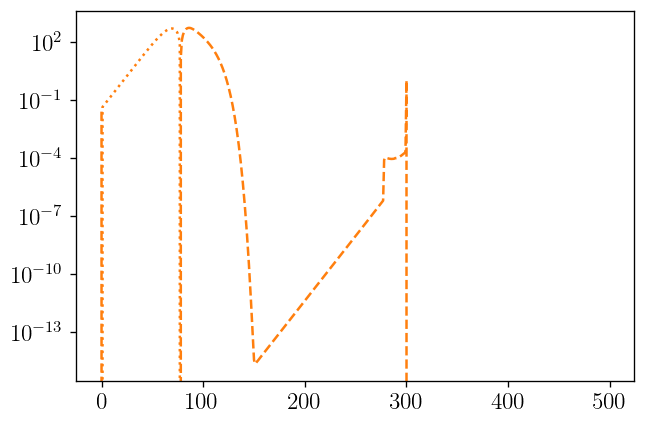

In [6]:
plt.plot(dc_N, color='C1', ls='--')
plt.plot(-dc_N, color='C1', ls=':')
plt.yscale('log')

In [7]:
import h5py

In [8]:
with h5py.File(os.environ['DM21CM_DATA_DIR'] + '/tf/zf01/phot_phot.h5', 'r') as hf:
    data = hf['data'][()]

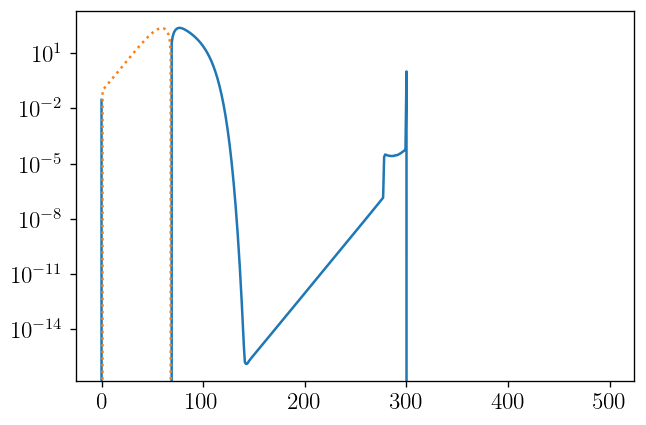

In [9]:
plt.plot(data[5, 300, 5, 5])
plt.plot(-data[5, 300, 5, 5], ls=':')
plt.yscale('log')